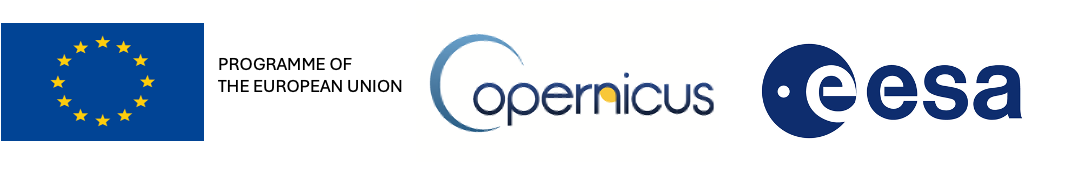

# SENTINEL-1 L2 OCN Product Format Prototype

## Table of Contents
TODO

## Introduction
In this notebook we will show examples of L2 OCN products and plotting examples with Xarray.


**Objectives**:  
   - Provide ready-to-use datasets and data variables
   - Adhere to conventions that allow the access to the product with external tools: CF-conventions, STAC

**Relevant Features**:  
   - Coordinates associated to measurement data are geographic coordinates and wind/wave/radial-velocity cell indexes. Future versions will include azimuth and range image coordinates
   - The zarr product adheres to CF conventions (this allows the user to open the product with standards tools such as xarray, exploiting data coordinates properly)
   - STAC attributes (will be added in the future)

**Notes**:

These are preliminary example products.

   - Not all metadata are included in these product prototypes, but will be included in the future.
   - Names of variables and attributes are preliminary and may change in the future.
   - STAC attributes are still to be defined.
   - Variable attributes will be refined in the future, including:
     - long_name
     - units
     - standard names for coordinates.
   - The chunking is not defined yet.
   - Products naming convention is to be defined.

# CHANGES TEMP REMOVE BEFORE COMMIT
- remove section on local file download and reading
- Replace XarrayStore with EOZarrStore
- TODO: S3 Data access instead of HTTPS

## Import modules

Dependencies

- datatree
- eopf
- xarray
- matplotlib

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from eopf.store.zarr import EOZarrStore

## Load and filter the data 

In [ ]:
s3_link = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S1A_S5_OCN__2SDV_20230315T185328_20230315T185357_047658_05B968_C2AE.zarr"

datatree = xr.open_datatree(s3_link, engine="zarr")

osw = datatree["/osw"]
owi = datatree["/owi"]
rvl = datatree["/rvl"]

#owi

## Examples of product usage
### Ocean Wind Field (OWI)
**open data**

In [ ]:
owi = owi["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]

In [ ]:

# Access the polarisation group or variable within the OWI group
polarisation = owi.conditions["polarisation"]

# Print the polarisation data
print("Polarisation:", polarisation.values)

## Wind speed

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
owi.measurements.wind_speed.plot(ax=ax[0])

polarisation_index = 0
#polarisations = owi.measurements.polarisation.attrs['flag_meanings'].split()
polarisations = owi.conditions["polarisation"]
owi.conditions.nrcs[...,polarisation_index].plot(ax=ax[1], vmax=0.04)
ax[0].set_title("Wind speed from copolarised channel")
ax[1].set_title(f"NRCS [m^2/m^2] averaged on OWI grid (polarisation: {polarisations[polarisation_index]})")
plt.show()

## Wind direction

Note that in the following plot wind directions are in meteorological convention (directions are measured clockwise from North) without taking into account the platform heading



In [ ]:
owi.measurements.wind_direction.plot()
plt.title("Wind direction in meteorological convention")
plt.show()

## Wind field in geographic projection

Vectors can be plotted using the `plot.quiver` method, but `u` and `y` vector components are required as separate variables.

Wind data is provided as a pair of dataarrays:

   - `wind_speed:` wind vector module
   - `wind_direction:` angle of the wind vector in meteorological convention

The `matplotlib.pyplot.quiver` method can be used to plot vectors by computing `u` and `v` vector components.

`x` and `y` point coordinates can optionally be passed as arguments.

Providing `lat` and `lon` values projects the data onto geographical coordinates.

**Plot**

In [ ]:
owi

In [ ]:
def get_vector_uv(norm, direction, heading=0):
    direction = (direction - heading) # conversion from wind direction wrt north to wind direction wrt azimuth
    direction += 180.  # conversion from meteorological to oceanographic conventions ("from where the wind comes" to "to where the wind goes")
    direction = 90 - direction # conversion from (z-axis, clockwise) angle to cartesian convention (x-axis, anti-clockwise))
    u = norm * np.cos(np.deg2rad(direction))
    v = norm * np.sin(np.deg2rad(direction))
    return u, v

stride = 5
wind_speed = owi.measurements.wind_speed[::stride, ::stride] # also as the arrow color criterion
wind_dir = owi.measurements.wind_direction[::stride, ::stride]
u, v = get_vector_uv(wind_speed, wind_dir)
cp = plt.contourf(owi.measurements.longitude, owi.measurements.latitude, owi.measurements.wind_speed, cmap='jet')
plt.quiver(owi.measurements.longitude[::stride, ::stride], owi.measurements.latitude[::stride, ::stride], u, v, wind_speed)
cbar = plt.colorbar(cp)
cbar.ax.set_ylabel(owi.measurements.wind_speed._eopf_attrs['long_name'] + f" [{owi.measurements.wind_speed._eopf_attrs['units']}]")
plt.xlabel(owi.measurements.longitude.attrs['long_name'])
plt.ylabel(owi.measurements.latitude.attrs['long_name'])
plt.title("Wind Field")
plt.show()

## Ocean Swell Wave (OSW)

In [ ]:
osw = osw["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]
osw

### Normalized Radar Cross Section (NRCS) averaged on OSW grid

In [ ]:
osw.conditions.nrcs.plot()
plt.title("NRCS [dB] averaged on OSW grid")
plt.show()

### Significant wave height

In [ ]:
partition_index = 0
osw.measurements.hs[...,partition_index].plot()
plt.title(f"Significant Wave Height [m] (partition: {partition_index})")
plt.show()

### Dominant Wave Length


In [ ]:
partition_index = 0
osw.measurements.wave_length[...,partition_index].plot()
plt.title(f"Dominant Wave Length [m] (partition: {partition_index})")
plt.show()

### Swell wave field in geographic projection

In [ ]:
partition_index = 0
wave_direction = osw.measurements.wave_direction[...,partition_index]
wave_height = osw.measurements.hs[...,partition_index]
u, v = get_vector_uv(wave_height, wave_direction)
cp = plt.contourf(osw.measurements.longitude, osw.measurements.latitude, wave_height, cmap='jet')
cbar = plt.colorbar(cp)

plt.quiver(osw.measurements.longitude, osw.measurements.latitude, u, v, cmap='jet')
cbar.ax.set_ylabel(osw.measurements.hs._eopf_attrs['long_name'] + f" [{osw.measurements.hs.attrs['units']}]")
plt.xlabel(osw.measurements.longitude.attrs['long_name'])
plt.ylabel(osw.measurements.latitude.attrs['long_name'])
plt.title(f"Swell Wave Field (partition: {partition_index})")
plt.show()

### Swell Spectrum in polar coordinates

In [ ]:
cell_index = 10, 2
osw.conditions.polar_spectrum[cell_index].plot()
plt.title(f"Swell Spectrum in Polar Coordinates (cell: {list(cell_index)})")
plt.show()

In [ ]:
owi = owi["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]

osw = osw["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]

owi

### Oversampling of significant wave height on OWI grid

In [ ]:
owi_az_idx = owi.conditions.az_cell_idx.values
owi_ra_idx = owi.conditions.ra_cell_idx.values
osw_az_idx = osw.measurements.az_cell_idx.values
osw_ra_idx = osw.measurements.ra_cell_idx.values

az_idx_ratio = np.ceil(owi_az_idx.max() / osw_az_idx.max())
ra_idx_ratio = np.ceil(owi_ra_idx.max() / osw_ra_idx.max())
partition_index = 0
osw.measurements.hs[...,partition_index].assign_coords(
    az_cell_idx=az_idx_ratio*osw.measurements.hs.az_cell_idx,
    ra_cell_idx=ra_idx_ratio*osw.measurements.hs.ra_cell_idx
).interp(
    az_cell_idx=owi_az_idx,
    ra_cell_idx=owi_ra_idx,
    method='linear',
).plot()
plt.title(f"Wave Height Oversampled onto OWI grid (partition: {partition_index})")
plt.show()

### Ocean Radial Velocity (RVL)

In [ ]:
rvl = datatree["/rvl"]
rvl

In [ ]:
rvl = rvl["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]

### Radial velocity in geographic projection

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
rvl.measurements.radial_velocity.plot(x='longitude', y='latitude', vmax=0, ax=ax[0])
rvl.measurements.radial_velocity_standard_deviation.plot(x='longitude', y='latitude', ax=ax[1], vmax=0.05)
ax[0].set_title("Radial Velocity [m/s]")
ax[1].set_title("Radial Velocity Standard Deviation [m/s]")
plt.show()